# Ford GoBike System Data Exploration
## by Bilal Karim

### Preliminary Wrangling

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area for the month of February 2019. It was provided as one of the data set options by Udacity and can be found on the Project Details page. The provided csv file contains 183,412 records.

In [28]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

#Enabling in-line plots for matplotlib
%matplotlib inline

#Setting base color for plots
base_color = sb.color_palette()[0]

In [29]:
df = pd.read_csv('201902-fordgobike-tripdata.csv')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [30]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

(None,
         duration_sec  start_station_id  start_station_latitude  \
 count  183412.000000     183215.000000           183412.000000   
 mean      726.078435        138.590427               37.771223   
 std      1794.389780        111.778864                0.099581   
 min        61.000000          3.000000               37.317298   
 25%       325.000000         47.000000               37.770083   
 50%       514.000000        104.000000               37.780760   
 75%       796.000000        239.000000               37.797280   
 max     85444.000000        398.000000               37.880222   
 
        start_station_longitude  end_station_id  end_station_latitude  \
 count            183412.000000   183215.000000         183412.000000   
 mean               -122.352664      136.249123             37.771427   
 std                   0.117097      111.515131              0.099490   
 min                -122.453704        3.000000             37.317298   
 25%                -12

In [31]:
df.isna().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

There are some columns that will need to be converted into different formats for better analysis:
* Trip start and end times can be converted to date/time format.
* Bike_share_for_all trip and user type and gender can be converted to boolean and category formats respectively.

I will also convert member birth year to an integer format; however, this column will require deeper analysis to identify and remove outliers (the minimum birth year in the data is `1878`) and null values. This will be made easier by deriving a "user age" column by subtracting the member's birth year from the year part of the trip start time column. That column should also be in integer format.

Additionally, there are a number of rows with null station ID and names. I will explore these rows and remove them if they do not help our analysis.

Finally, I will create a column to denote whether trip was to or from a public transit station. If either a trip start or end station name contains either 'BART' or 'Caltrain', this condition will be True.

In [32]:
# Convert datetime columns to appropriate format
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_time'] = pd.to_datetime(df['start_time'])

In [33]:
# Convert bike_share_for_all_trip and user type and gender columns to categorical and boolean formats
df['user_type'] = df['user_type'].astype('category')
df['bike_share_for_all_trip'] = df['bike_share_for_all_trip'] == 'Yes'

In [34]:
# Create a column to denote whether trip was to or from a mass transit station
df['transit_station_trip'] = (df['start_station_name']+df['end_station_name']).str.contains('BART|Caltrain', regex=True)

Now, I will create a user age column and dive deeper into the member birth year column to identify and remove outliers.

In [35]:
df['user_age'] = df['start_time'].dt.year - df['member_birth_year']

In [36]:
df['user_age'].describe(percentiles=[0.10, 0.25, 0.5, 0.75, 0.90, 0.99])

count    175147.000000
mean         34.193563
std          10.116689
min          18.000000
10%          24.000000
25%          27.000000
50%          32.000000
75%          39.000000
90%          49.000000
99%          64.000000
max         141.000000
Name: user_age, dtype: float64

In [37]:
df['member_birth_year'].describe(percentiles=[0.10, 0.25, 0.5, 0.75, 0.90, 0.99])

count    175147.000000
mean       1984.806437
std          10.116689
min        1878.000000
10%        1970.000000
25%        1980.000000
50%        1987.000000
75%        1992.000000
90%        1995.000000
99%        1999.000000
max        2001.000000
Name: member_birth_year, dtype: float64

Judging from the information above, the majority of the users in the data are 64 years and younger (99th percentile in age = 64 years). I will assume that any users above that age are outliers and should be removed from the analysis for actionable findings. I will do that now:

In [38]:
df = df[df['user_age'] <= 66]

In [39]:
df['member_birth_year'].isna().sum()

0

Removing the outlier values also removed the nulls in the `member_birth year` column. This can now be converted into integer format along with the newly-created `user_age` column.

In [40]:
# Convert member birth year and user age to integer columns
df['member_birth_year'] = df['member_birth_year'].astype(int)
df['user_age'] = df['user_age'].astype(int)

In [41]:
df = df[df['start_station_id'].notnull()]
df.reset_index(drop=True,inplace=True)

In [42]:
df['member_gender'].value_counts(1)

Male      0.745376
Female    0.233919
Other     0.020704
Name: member_gender, dtype: float64

The 'Other' category makes up a very small percentage of the data set. I will remove these values from the bivariate and multivariate plots, so as to not muddy the insights about the rest of the data.

In [43]:
df = df[df['member_gender'] != 'Other']

I will now remove the columns we are either not going to use in our analysis, or have a better substitute for in the data set: Start/end station IDs and latitude and longitude data, bike ID, and member birth year.

In [44]:
columns_to_drop = ['start_station_id', 'start_station_latitude','start_station_longitude',
                   'end_station_id', 'end_station_latitude','end_station_longitude',
                   'bike_id','member_birth_year']
df.drop(columns=df[columns_to_drop], inplace=True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170134 entries, 0 to 173730
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             170134 non-null  int64         
 1   start_time               170134 non-null  datetime64[ns]
 2   end_time                 170134 non-null  datetime64[ns]
 3   start_station_name       170134 non-null  object        
 4   end_station_name         170134 non-null  object        
 5   user_type                170134 non-null  category      
 6   member_gender            170134 non-null  object        
 7   bike_share_for_all_trip  170134 non-null  bool          
 8   transit_station_trip     170134 non-null  object        
 9   user_age                 170134 non-null  int64         
dtypes: bool(1), category(1), datetime64[ns](2), int64(2), object(4)
memory usage: 12.0+ MB


In [20]:
df['start_station_name'].nunique(), df['end_station_name'].nunique()

(329, 329)

### What is the structure of your dataset?

The cleaned data set contains information about 170,134 trips spanning 329 unique stations. There is no data identifying individual riders, so we cannot determine the characteristics outside of the given information (birth year, gender, and user type). There were outliers in the `member_birth_year` column in the data that I excluded from the analysis.

### What is/are the main feature(s) of interest in your dataset?

I am interested in finding out which features in the data set are best to predict ride duration.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that trip duration will be higher on weekends than on weekdays, as users take more leisure trips then. The weekend trips will also be a more even mix of subscribers and customers, as tourists will likely rent bikes to move around the Bay area. I also expect the time of day and both trip start and end station names will have some effect on trip duration, as trips taken during popular commute times on weekdays (mornings and evenings) will have been mainly to and from public transit stations. Finally, from the rider characteristics provided, age will be an important factor - younger riders will likely have longer and more frequent trips than older riders. 

## Univariate Exploration

#### I'll start by looking at the main variable of interest: trip duration (in seconds).

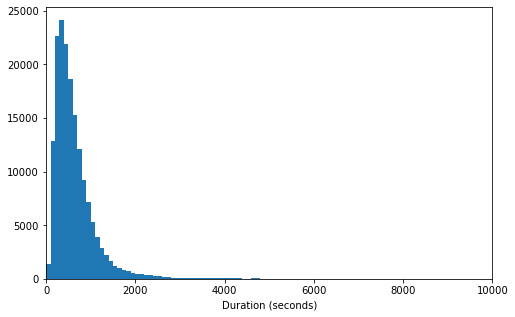

In [94]:
# start with a standard-scaled plot
binsize = 100
bins = np.arange(0, df['duration_sec'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.xlabel('Duration (seconds)')
plt.hist(data=df, x='duration_sec', bins=bins)
plt.xlim(0,10000)
plt.show()

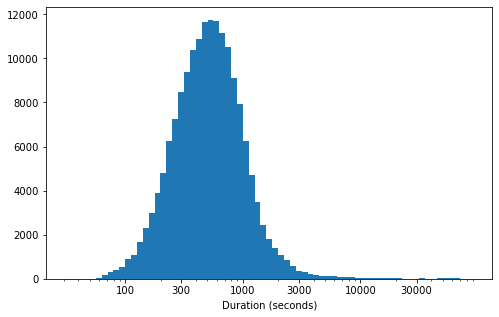

In [95]:
# The data seems highly skewed, so we can try placing it on a log scale instead
log_binsize = 0.05
bins = 10 ** np.arange(1.5, np.log10(df['duration_sec'].max())+log_binsize, log_binsize)
ticks = [100, 300, 1000, 3000, 10000, 30000]
labels = ['{}'.format(v) for v in ticks]
plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlabel('Duration (seconds)')
plt.show()

Trip duration has a right-skewed distribution, with a lot of trips having a low duration and a few having very high duration. When plotted on a log-scale, the same distribution looks approximately normal, with a peak around 600 seconds (~10 minutes). It appears that a majority of trips are short in length, with only a few trips making it past the 1-hour (3600 seconds) mark. I will create a log-transformed trip duration column to use for bivariate and multivariate plots, if needed.

In [49]:
def log_trans(x, inverse = False):
    """ function to compute log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)
    
df['duration_sec_log'] = df['duration_sec'].apply(log_trans)

#### Next up, I will look the date/time related predictor variables.

I will start by looking at the day of week.

In [50]:
# Creating a column for the day of week for the trip
df['trip_start_day'] = df['start_time'].dt.day_name()

# Converting trip_start_day into an ordered categorical type column
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ordered_days = pd.api.types.CategoricalDtype(ordered=True, categories=days_order)
df['trip_start_day'] = df['trip_start_day'].astype(ordered_days);

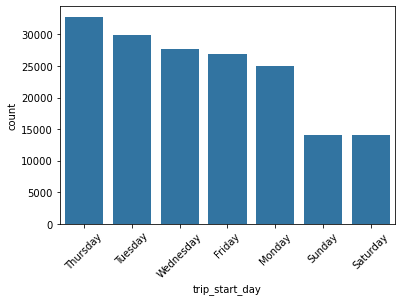

In [51]:
#Getting bar order for the highest-to-lowest number of trips
order = df['trip_start_day'].value_counts().index

# Bar plot to show the number of trips by day
sb.countplot(data=df, x='trip_start_day', color=base_color, order=order)
plt.xticks(rotation=45);

It appears that the most number of trips occur on weekdays, with Thursday being the busiest day. Weekends seem to be significantly less busy in terms of the number of rides taken. 

From the same column (trip start time), I will also derive a "hour" column to understand the times of day when trips are made.

In [52]:
df['trip_start_hour'] = df['start_time'].dt.hour

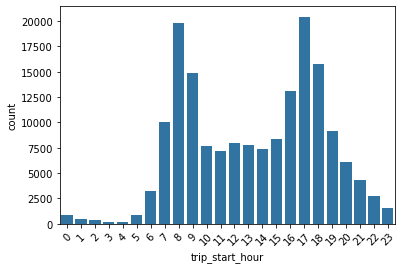

In [53]:
# Bar plot to show the number of trips by hour
sb.countplot(data=df, x='trip_start_hour', color=base_color)
plt.xticks(rotation=45);

I will segment the hourly data into 5 time-of-day categories to draw insights more effectively:
1. Morning: 6am - 11am
2. Afternoon: 12pm - 4pm
3. Evening: 5pm - 7pm
4. Night: 8pm - 11pm
5. Late night: 12am - 5am

In [54]:
# Creating a column containing time-of-day categories for segmented hourly data
bins = [0, 5, 11, 16, 19, 23]
groups = ['late_night', 'morning', 'afternoon', 'evening', 'night']
df['timeofday'] = pd.cut(df['trip_start_hour'], bins, labels = groups, include_lowest=True)

# Converting time-of-day column to an ordered categorical type
dayoftime_order = ['morning', 'afternoon', 'evening', 'night', 'late_night']
ordered_daytime = pd.api.types.CategoricalDtype(ordered=True, categories=dayoftime_order)
df['timeofday'] = df['timeofday'].astype(ordered_daytime)

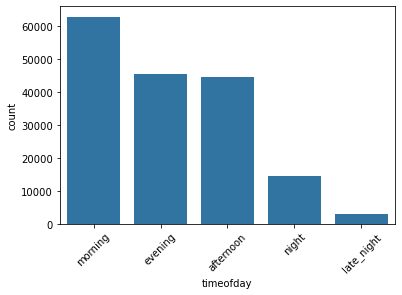

In [55]:
# Deriving order for time categories from most common to least common
order = df['timeofday'].value_counts().index
# Visualizing the newly-categorized data to identify popular ride times
sb.countplot(data=df, x='timeofday', color=base_color, order = order)
plt.xticks(rotation=45);

It appears that morning and evening trips are the most common in the data set. These times are usually those where people commute to and from their work. Night-time are the least popular for trip start time.

#### I will next look at the rider characteristics in the data set.

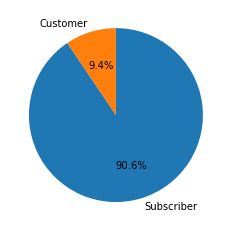

In [56]:
# Subscriber vs. customer mix in the data set
sorted_counts = df['user_type'].value_counts(1)

plt.pie(sorted_counts, labels = sorted_counts.index, autopct = '%1.1f%%', startangle = 90, counterclock = False);

The data set mainly consists of data from subscribers.

Looking at the mix of gender data provided:

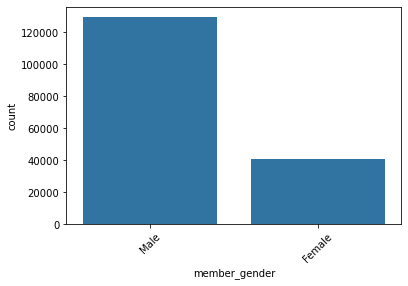

In [57]:
sb.countplot(data=df, x='member_gender', color=base_color)
plt.xticks(rotation=45);

Now, I will look at the user age mix in the data:

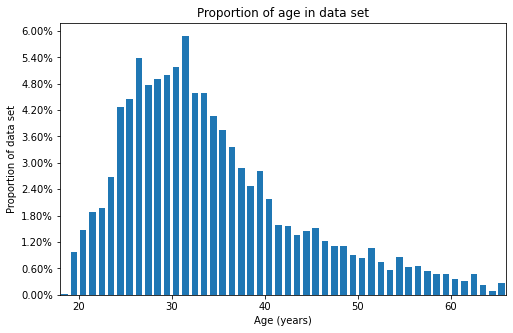

In [58]:
#Setting bin size to 1 year per bar
binsize = 1
bins = np.arange(0, df['user_age'].max()+binsize, binsize)

# Getting user age proportions to change y axis ticks to relative frequency
users_counts = df['user_age'].value_counts()
users_order = users_counts.index
n_users = users_counts.sum()
max_prop =  users_counts.max()/n_users
tick_props = np.arange(0, max_prop+0.006, 0.006)
tick_names = ['{:0.2f}%'.format(v*100) for v in tick_props]

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'user_age', bins = bins, rwidth=0.7)
plt.xlabel('Age (years)')
plt.xlim(df['user_age'].min(),df['user_age'].max())
plt.yticks(tick_props * n_users,tick_names)
plt.ylabel('Proportion of data set')
plt.title('Proportion of age in data set')
plt.show()

The users' age data is slightly skewed to the right, with a large population of 31 and 26 year olds.

#### Finally, I will explore the station-related data that are represented in the data set

As the raw number of stations are far too many to show legibly in a frequency or count plot, I will focus on identifying the most common stations. In the bivariate section, I will be able to further analyze this feature alongside others.

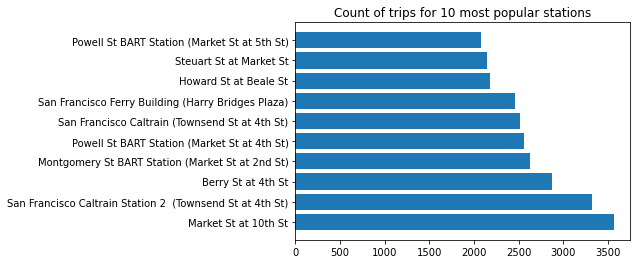

In [59]:
# Get the unique values of the `start_station_name` column, in the decreasing order of the frequency
popular_stations = df['start_station_name'].value_counts()[:10].index.tolist()
pop_station_counts = df['start_station_name'].value_counts()[:10].tolist()

plt.barh(y=popular_stations, width=pop_station_counts, color=base_color)
plt.title('Count of trips for 10 most popular stations');

Next, I will plot the values in the boolean columns that are related to the trip, i.e. if the trip was made to or from a transit station and whether or not the bike was rented for the entirety of the trip.

This will be more intuitive to summarize findings with as compared to using the large number of station names.

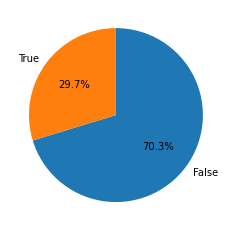

In [60]:
# Values in transit_station_trip
sorted_counts = df['transit_station_trip'].value_counts(1)

plt.pie(sorted_counts, labels = sorted_counts.index, autopct = '%1.1f%%', startangle = 90, counterclock = False);

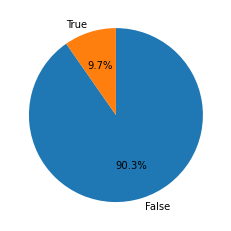

In [61]:
# Values in bike_share_for_all_trip
sorted_counts = df['bike_share_for_all_trip'].value_counts(1)

plt.pie(sorted_counts, labels = sorted_counts.index, autopct = '%1.1f%%', startangle = 90, counterclock = False);

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The trip duration variable took on a very large range of values (from 61 seconds to nearly 24 hours) and appeared very skewed. Plotting the same data after a log transformation, the distrubution looked approximately normal. This suggests that the majority of use cases for the rideshare service involve quick and short trips.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

When investigating the data set, I made a few transformations:
1. I changed the data type for a few features to enhance the quality and accuracy of analyses (e.g. changed the datetime and categorical variables to the appropriate formats), 
2. I identified that there were outliers in the member birth year column by creating a user_age column and examining the age range of the members in the data set. The rows with outliers and null values were dropped,
3. I derived additional features:
  1. Day of week from the ride start time, as that could be an interesting angle to explore the trip duration from, especially combined with the other features,
  2. Whether or not a trip involved a public transit station, as that could potentially correlate with the most popular times for rides as we have seen in the Univariate exploration section,
  3. I created a log-transformed `duration_sec` column for further analyses, as distribution for that variable appeared very skewed when plotted on a histogram,
  4. I binned the trip start hour data into time-based segments, namely: late night, morning, afternoon, evening, and night. I converted this to an ordered categorical data type to logically force the time of day logic by default.
4. There were rows with null values in the station ID and name columns. As all location information was missing from those rows, I removed those rows as this may have been due to errors in telemetry/data entry,
5. Looking at the `member_gender` values, it seems that the 'Other' category may end up clouding insights as it makes up a very small percentage of the data (2.07%). I removed those values from the data set.

In terms of unusual distributions, I was surprised by the fact that Thursdays are the busiest days of the week for the ride share service. This will be an interesting point to follow up on in the bivariate and multivariate analyses.

## Bivariate Exploration

I will start off by exploring relationships between the date/time variables and average trip duration. I will then explore the rider characteristics (`user_type`, `member_gender`, and `user_age`). I will close out the section by exploring whether station and/or trip characteristics (e.g. `bike_share_for_all_trip` and `transit_station_trip`) affect trip duration.

#### Date/time variables

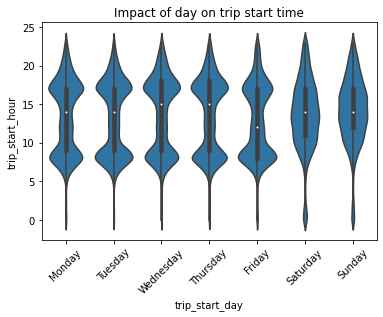

In [62]:
sb.violinplot(data=df, x='trip_start_day', y='trip_start_hour', color=base_color)
plt.xticks(rotation=45)
plt.title('Impact of day on trip start time');

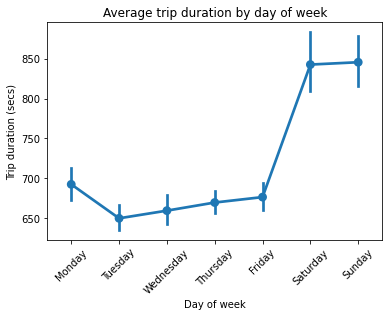

In [63]:
ticks = np.arange(600, 950, 50)
labels = ['{}'.format(v) for v in ticks]
sb.pointplot(data= df, x='trip_start_day', y='duration_sec', color=base_color)
plt.xlabel('Day of week')
plt.ylabel('Average trip duration (seconds)')
plt.xticks(rotation=45)
plt.ylabel('Trip duration (secs)')
plt.title('Average trip duration by day of week');

''

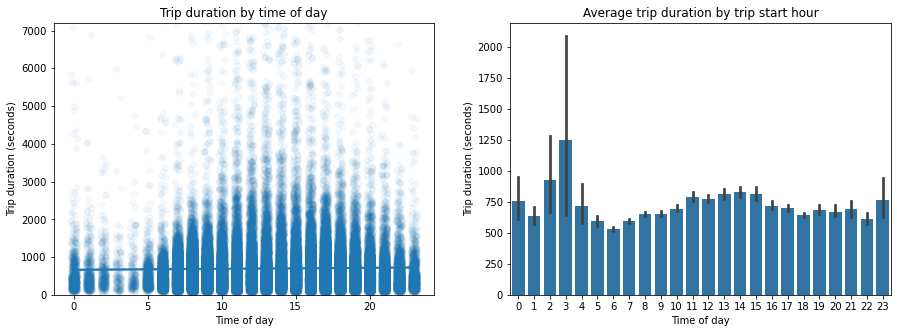

In [64]:
plt.figure(figsize = [15, 5])
plt.subplot(1, 2, 1) 
sb.regplot(x = df['trip_start_hour'], y = df['duration_sec'],color=base_color,x_jitter=0.2,scatter_kws={'alpha':1/25}, fit_reg=True)
plt.xlabel('Time of day') 
plt.ylabel('Trip duration (seconds)')
plt.title('Trip duration by time of day')
plt.ylim(0,7200);

plt.subplot(1, 2, 2)
sb.barplot(data = df, x = 'trip_start_hour', y = 'duration_sec', color=base_color)
plt.xlabel('Time of day') 
plt.ylabel('Trip duration (seconds)')
plt.title('Average trip duration by trip start hour')
;

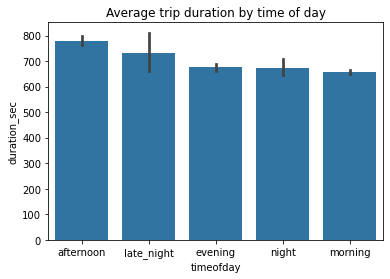

In [65]:
order = df.groupby(df['timeofday']).mean()['duration_sec'].sort_values(ascending=False).index
sb.barplot(data=df, x='timeofday', y='duration_sec', color=base_color, order=order)
plt.title('Average trip duration by time of day');

The trip start time is similar across weekdays, with a higher number of trips at popular commute times. Interestingly, even though Fridays generally have a similar pattern to the rest of the week, the dip after morning commute hours is much more gradual, indicating a more relaxed work start time on the last day of the week. Over the weekends, trip start times are more evenly distributed across the day and reach a mild peak around 3pm.

Average trip duration is higher on the weekends than on weekdays; this may be caused by more leisure trips being taken on the weekends than on weekdays.

Trips that start later in the day appear to be slightly longer in duration, although the smaller number of observations for "late night" increases the uncertainty in the trip duration average. I limited the scatterplot's y-axis to 7200 seconds (2 hours) so as to avoid losing insight due to the longer trips in the data.

#### User type

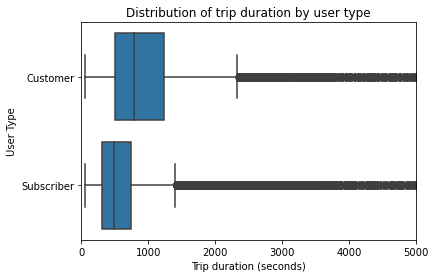

In [66]:
# Box plot comparing trip duration by user type
sb.boxplot(data = df, x = 'duration_sec', y = 'user_type', color = base_color)
plt.title('Distribution of trip duration by user type')
plt.xlabel('Trip duration (seconds)')
plt.ylabel('User Type')
plt.xlim(0,5000);

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


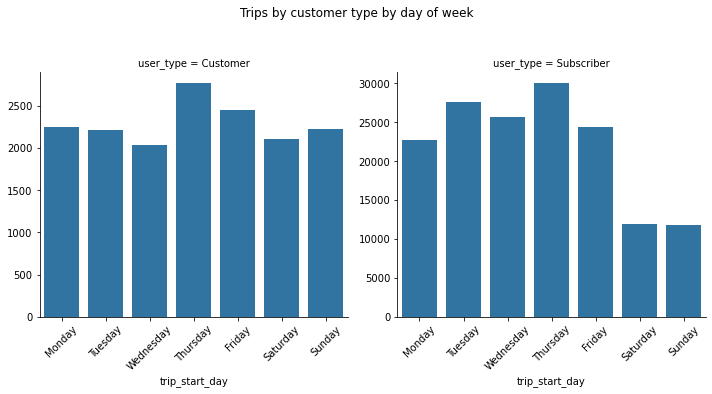

In [67]:
# User type ride count by day of week
g = sb.FacetGrid(data = df, col= 'user_type', sharey=False, height=5, aspect=1)
g.map(sb.countplot, 'trip_start_day')
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Trips by customer type by day of week');

Customers have a longer trip duration on average, whereas subscribers have a tighter inter-quartile range.

The plot of choice for exploring the count of trips by each customer type was a faceted count plot with independent y-axes, as they allows us to observe the change in trip count by weekday by user type more effectively. We can see here that the trips made by subscribers happen to drop off a lot on the weekends, whereas the number of trips by non-subscribers tend to stay relatively uniform across the week.

Next, I will look at number of trips made by each customer type at different times of the day.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


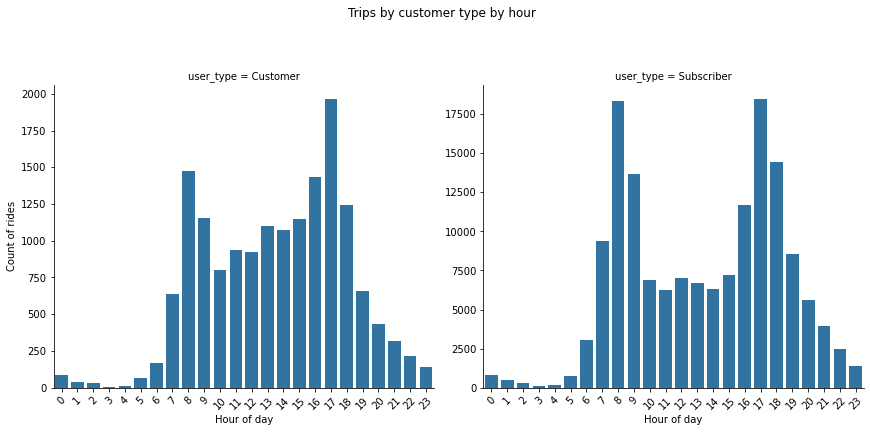

In [68]:
# User type trips by hour of day
g = sb.FacetGrid(data = df, col= 'user_type', sharey=False, height=6, aspect=1)
g.map(sb.countplot, 'trip_start_hour')
g.set_axis_labels("Hour of day", "Count of rides")
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Trips by customer type by hour');

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


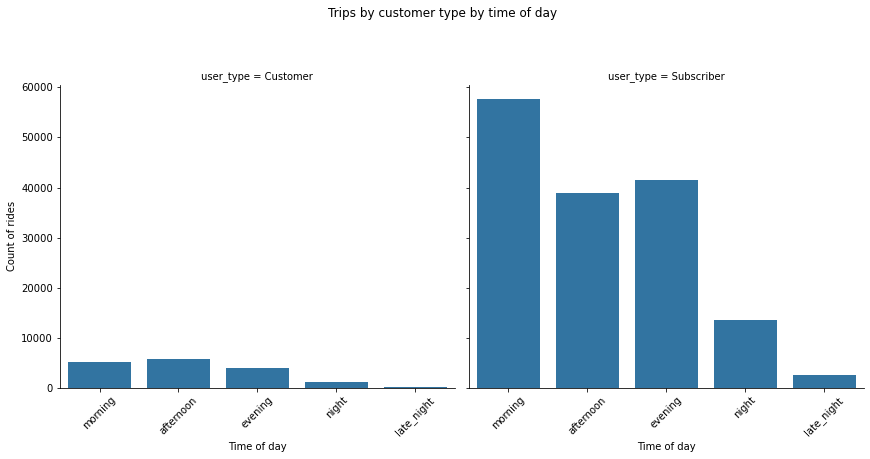

In [69]:
g = sb.FacetGrid(data = df, col= 'user_type', sharey=True, height=6, aspect=1)
g.map(sb.countplot, 'timeofday')
g.set_axis_labels("Time of day", "Count of rides")
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Trips by customer type by time of day');

Both customers and subscribers have the most trips around popular commute hours; however, the pattern is a lot more pronounced for subscribers than it is for customers. Subscribers are comparatively more active in the afternoons.

#### User age

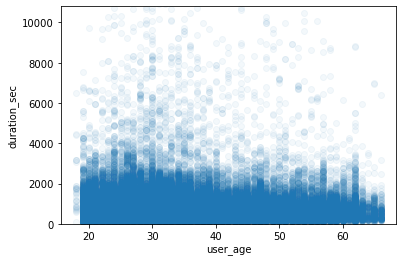

In [70]:
sb.regplot(data=df, x= 'user_age', y= 'duration_sec',scatter_kws={'alpha':1/20}, fit_reg=False)
plt.ylim(0,10800);

On average, trip duration has a negative correlation with user's age. 

#### User gender

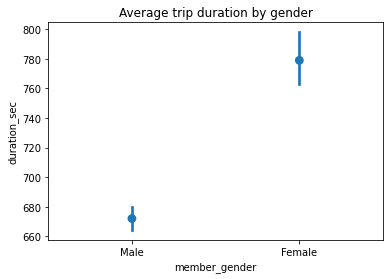

In [71]:
sb.pointplot(data=df, x='member_gender', y='duration_sec', color=base_color, linestyles = "")
plt.title('Average trip duration by gender');

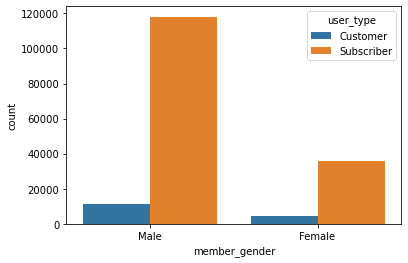

In [72]:
sb.countplot(data=df, x='member_gender', hue='user_type');

Females have higher trip duration on average than males; however, the lower count of records for females leads to a higher potential error rate in the mean.

#### Trip-specific characteristics exploration

I will start this section off by exploring the "transit station trip" variable.

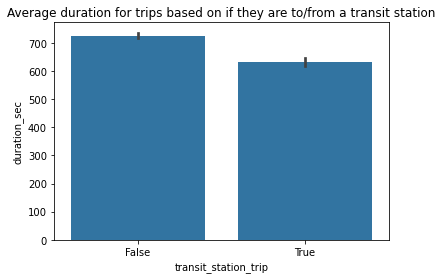

In [73]:
#Transit station trip vs. non-transit station trip effect on duration
sb.barplot(data=df, x='transit_station_trip', y='duration_sec', color=base_color)
plt.title('Average duration for trips based on if they are to/from a transit station');

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


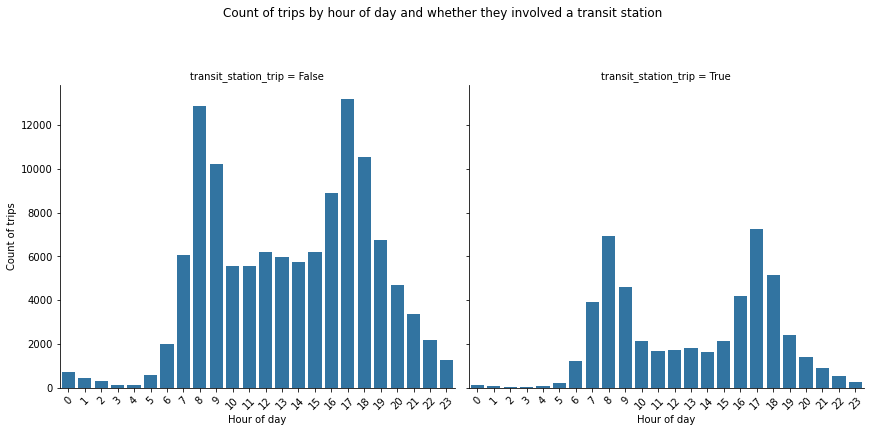

In [74]:
g = sb.FacetGrid(data = df, col= 'transit_station_trip', sharey=True, height=6, aspect=1)
g.map(sb.countplot, 'trip_start_hour')
g.set_axis_labels("Hour of day", "Count of trips")
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.8);
g.fig.suptitle('Count of trips by hour of day and whether they involved a transit station');

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


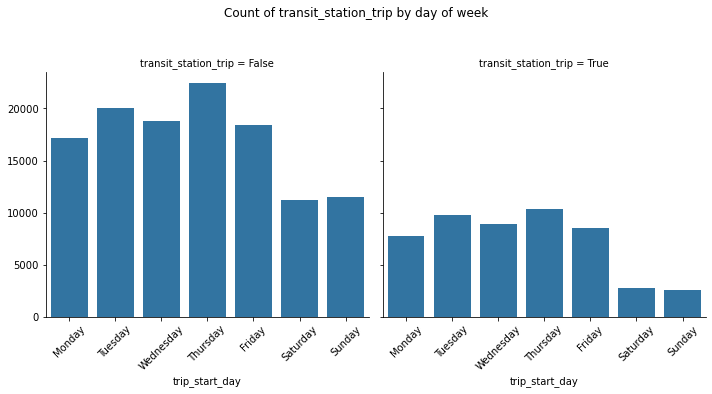

In [75]:
g = sb.FacetGrid(data = df, col= 'transit_station_trip', sharey=True, height=5, aspect=1)
g.map(sb.countplot, 'trip_start_day')
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Count of transit_station_trip by day of week');

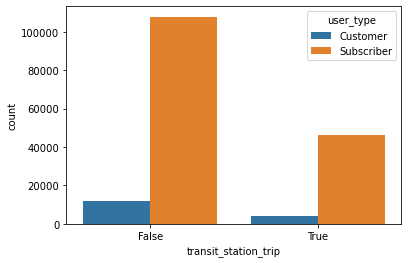

In [76]:
sb.countplot(data = df, x = 'transit_station_trip', hue = 'user_type');

The data set contains fewer trips that involved a transit station as either its origin or destination than other trips. The proportional difference of subscribers vs. customers in this delineation is not very insightful.

Next, I will look at differences between trips that used the bikeshare service for their entirety vs. those that did not.

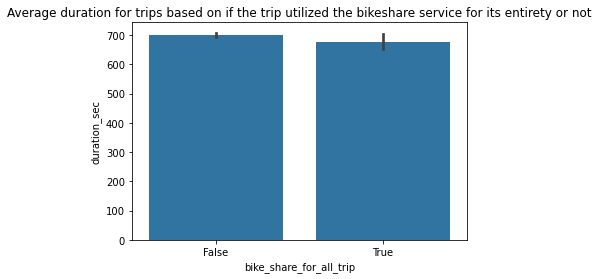

In [77]:
# Bike share for all trip vs. part of trip
sb.barplot(data=df, x='bike_share_for_all_trip', y='duration_sec', color=base_color)
plt.title('Average duration for trips based on if the trip utilized the bikeshare service for its entirety or not');

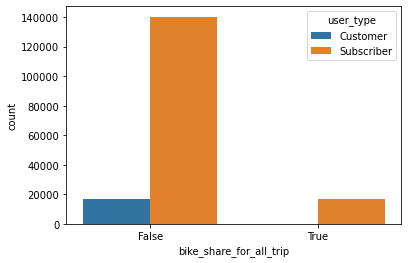

In [13]:
sb.countplot(data = df, x = 'bike_share_for_all_trip', hue = 'user_type');

If trips are to or from a transit station, they tend to be shorter on average. This would suggest that they may be part of a regular commute. The trips that do not involve a transit station are longer, suggesting that a large portion of that data reprents either leisure trips or users either commuting to or from their work.

The number of trips is higher at popular commute times, whether or not they involve a transit station. This is to be expected, as some users do not take mass transit to work, and would just be commuting to bike stations near their work or home. This can be further explored by observing the relationship between this variable and whether or not the bike share service was used for all or just part of the trip.

I want to close this section off by comparing `bike_share_for_all_trip` with `transit_station_trip`.

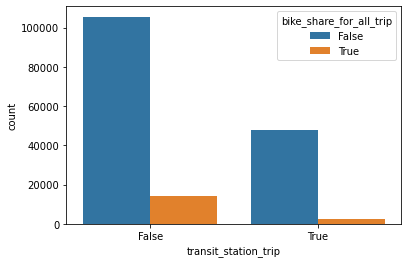

In [78]:
sb.countplot(data = df, x = 'transit_station_trip', hue = 'bike_share_for_all_trip');

There does not appear to be a strong correlation between trip duration and whether or not the bike share service was used for the entirety of the trip or not by itself.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

I noticed that trip duration seems to be greatly influenced by the time of day and day of week variables. Trips taken later in the day and on weekends are longer on average than those taken in the early morning or late night hours or on weekdays. The user type also affects trip duration a lot: customers tend to ride for longer on average than subscribers. They are also more consistent in their trip count across the week as compared to subscribers, who use the service more frequently during popular commute hours on weekdays.

Trip duration is also negatively correlated with user age - it is highest for users in their late 20s and early 30s, and tapers down gradually as the users get over 30 years in age. User gender is not a significant factor in determining trip duration either. For all provided genders, the bulk of trips are range from around 11 to 16 minutes. 

In general, trips that involve a transit station (either as a starting point or as a destnation) are shorter than trips that do not involve commute to or from a transit station. I found that there was no significant difference in duration between trips that used the bike share service for the entirety of the trip as compared to those that did not.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

In general, time of day is a strong predictor of bike share service usage - There are a larger proportion of trips during popular commute hours. Trips on weekends are also longer than those on weekdays; however as the dataset is limited to one month, the confidence with that hypothesis is low.

I found that the count of customers who used bike share for the entire trip is 0. This may have been caused by the data entry process or just that there is no way for non-subscribers to indicate whether or not they used the bikeshare service for all of the trip. This will not be relevant to the main subject of the analysis, so will not be explored further.

Additionally, it was interesting to note that although the trip start time on Fridays is similar to other weekdays, the rate at which trips drop off after the morning commute hours is slower than the other weekdays.

## Multivariate Exploration

In this section, I want to further analyze date/time interaction with trip duration, along with usage pattern differences across various user characteristics. I will close this section out by diving deeper into how the `transit_station_trip` variable interacts with other good predictors of trip duration.

### Date/time variables

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1800x1080 with 0 Axes>

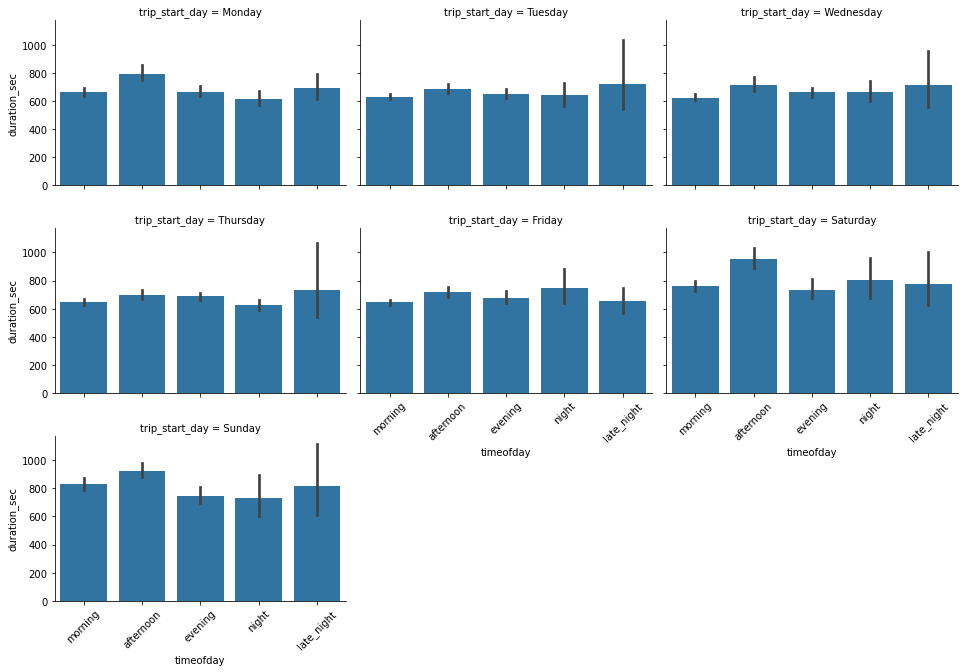

In [79]:
# Average trip duration by day of week and hour of day
plt.figure(figsize=[25, 15])
g = sb.FacetGrid(data = df, col = 'trip_start_day', aspect=1.5, col_wrap=3, sharey=True,
                margin_titles = True)
g.map(sb.barplot, 'timeofday', 'duration_sec')
g.set_xticklabels(rotation=45);

''

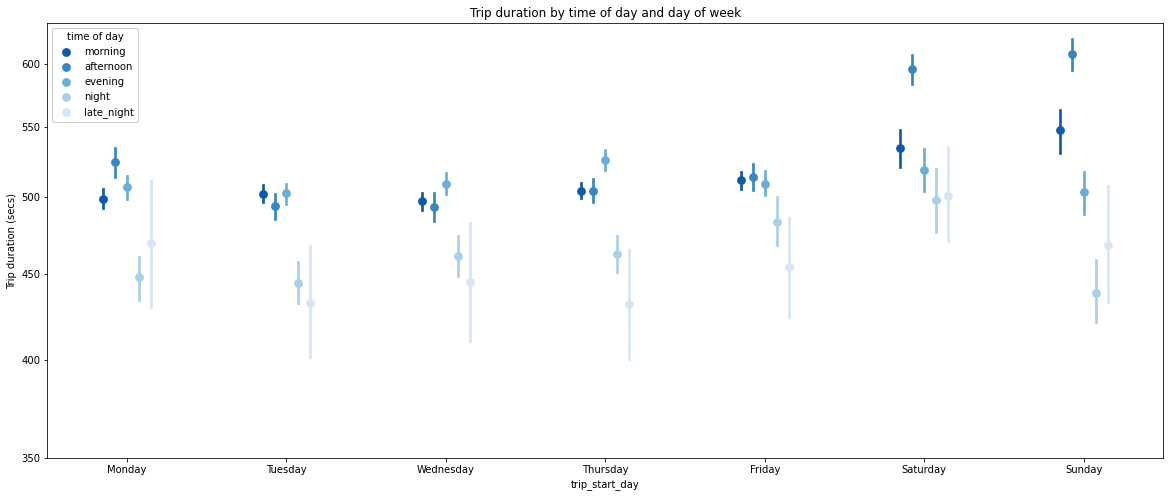

In [64]:
plt.figure(figsize=[20, 8])
ticks = [350, 400, 450, 500, 550, 600]
labels = ['{}'.format(v) for v in ticks]
bar = sb.pointplot(data = df, x = 'trip_start_day', y = 'duration_sec_log', hue = 'timeofday', dodge=0.3, linestyles = "", palette = 'Blues_r')
bar.legend(loc = 'upper left', ncol = 1, framealpha = 1, title = 'time of day')
plt.ylabel('Trip duration (secs)')
plt.yticks(log_trans(ticks), labels)
plt.title('Trip duration by time of day and day of week')
;

### User characteristics

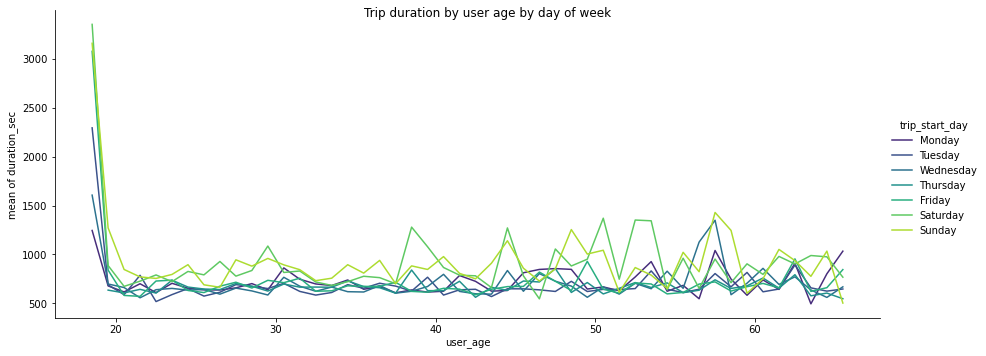

In [80]:
def mean_poly(x, y, bins = 10, **kwargs):
    """ Custom adapted line plot code. """
    # set bin edges if none or int specified
    if type(bins) == int:
        bins = np.linspace(x.min(), x.max(), bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # compute counts
    data_bins = pd.cut(x, bins, right = False,
                       include_lowest = True)
    means = y.groupby(data_bins).mean()

    # create plot
    plt.errorbar(x = bin_centers, y = means, **kwargs)

bin_edges = np.arange(18, df['user_age'].max()+1, 1)
g = sb.FacetGrid(data = df, hue = 'trip_start_day', height = 5, aspect = 20/8, palette='viridis')
g.map(mean_poly, "user_age", "duration_sec", bins = bin_edges)
g.set_ylabels('mean of duration_sec')
g.fig.suptitle('Trip duration by user age by day of week');
g.add_legend();

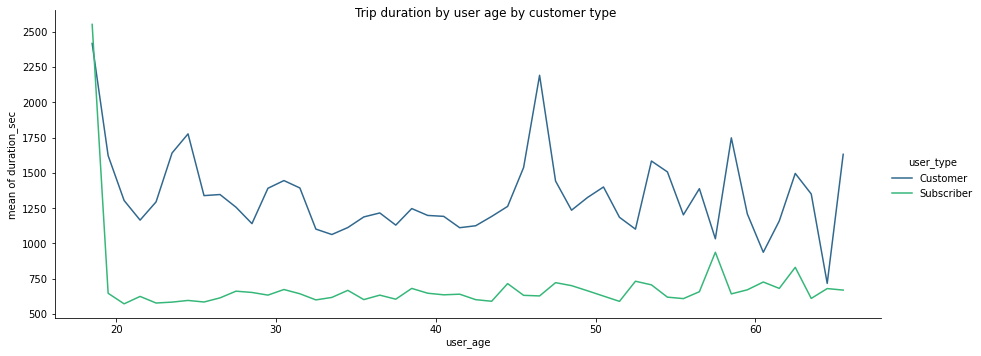

In [81]:
bin_edges = np.arange(18, df['user_age'].max()+1, 1)
g = sb.FacetGrid(data = df, hue = 'user_type', height = 5, aspect = 20/8, palette='viridis')
g.map(mean_poly, "user_age", "duration_sec", bins = bin_edges)
g.set_ylabels('mean of duration_sec')
g.fig.suptitle('Trip duration by user age by customer type')
g.add_legend();

Trips on weekends tend to be longer on average, regardless of user age. Trip duration is higher for users between the ages of 18 and 20 on all days of the week, relative to the rest of the population.

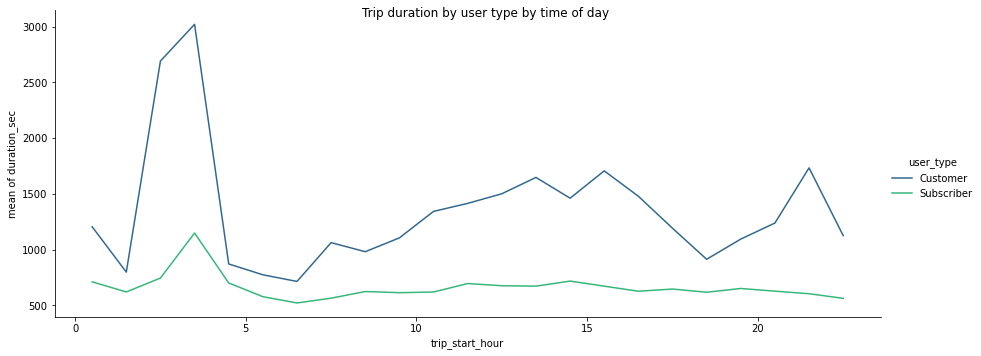

In [82]:
bin_edges = np.arange(0, df['trip_start_hour'].max()+1, 1)
g = sb.FacetGrid(data = df, hue = 'user_type', height = 5, aspect = 20/8, palette='viridis')
g.map(mean_poly, "trip_start_hour", "duration_sec", bins = bin_edges)
g.set_ylabels('mean of duration_sec')
g.fig.suptitle('Trip duration by user type by time of day')
g.add_legend();

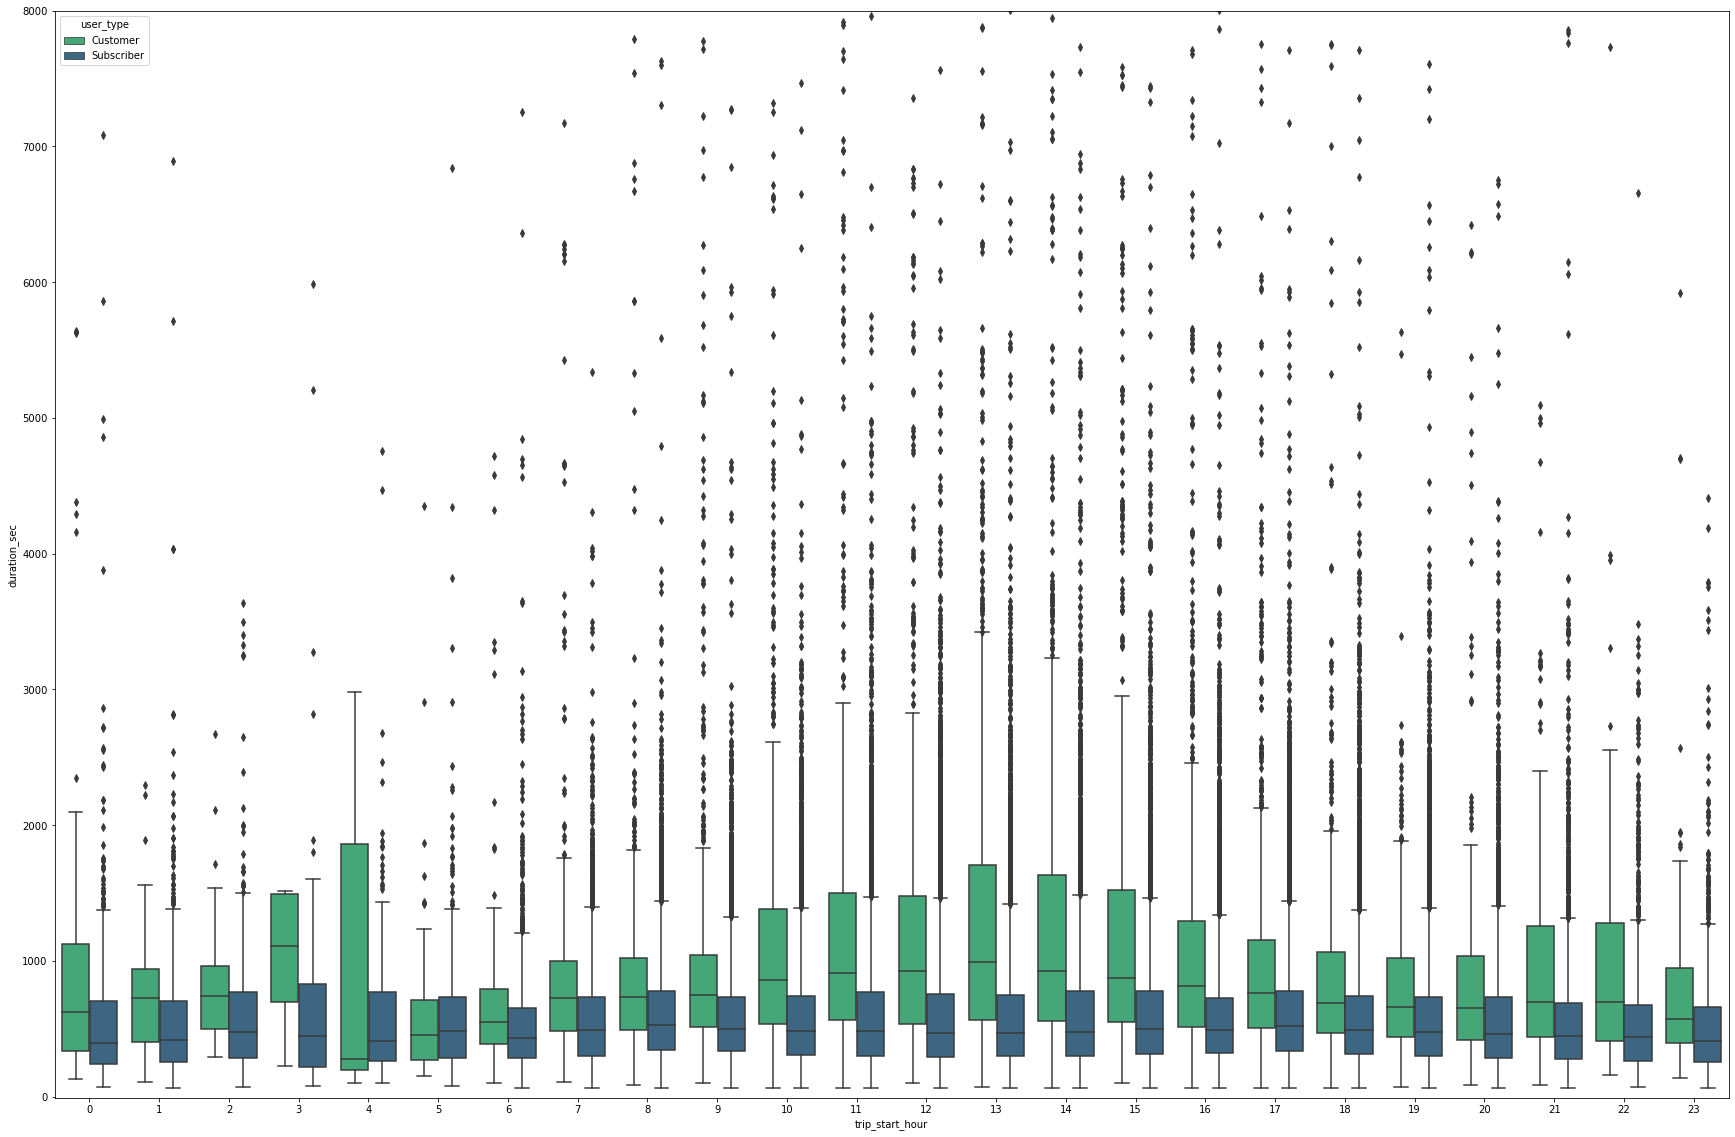

In [83]:
plt.figure(figsize=[30,20])
sb.boxplot(data=df, y='duration_sec', x='trip_start_hour', hue='user_type', palette='viridis_r')
plt.ylim(-10,8000);

<Figure size 2160x1440 with 0 Axes>

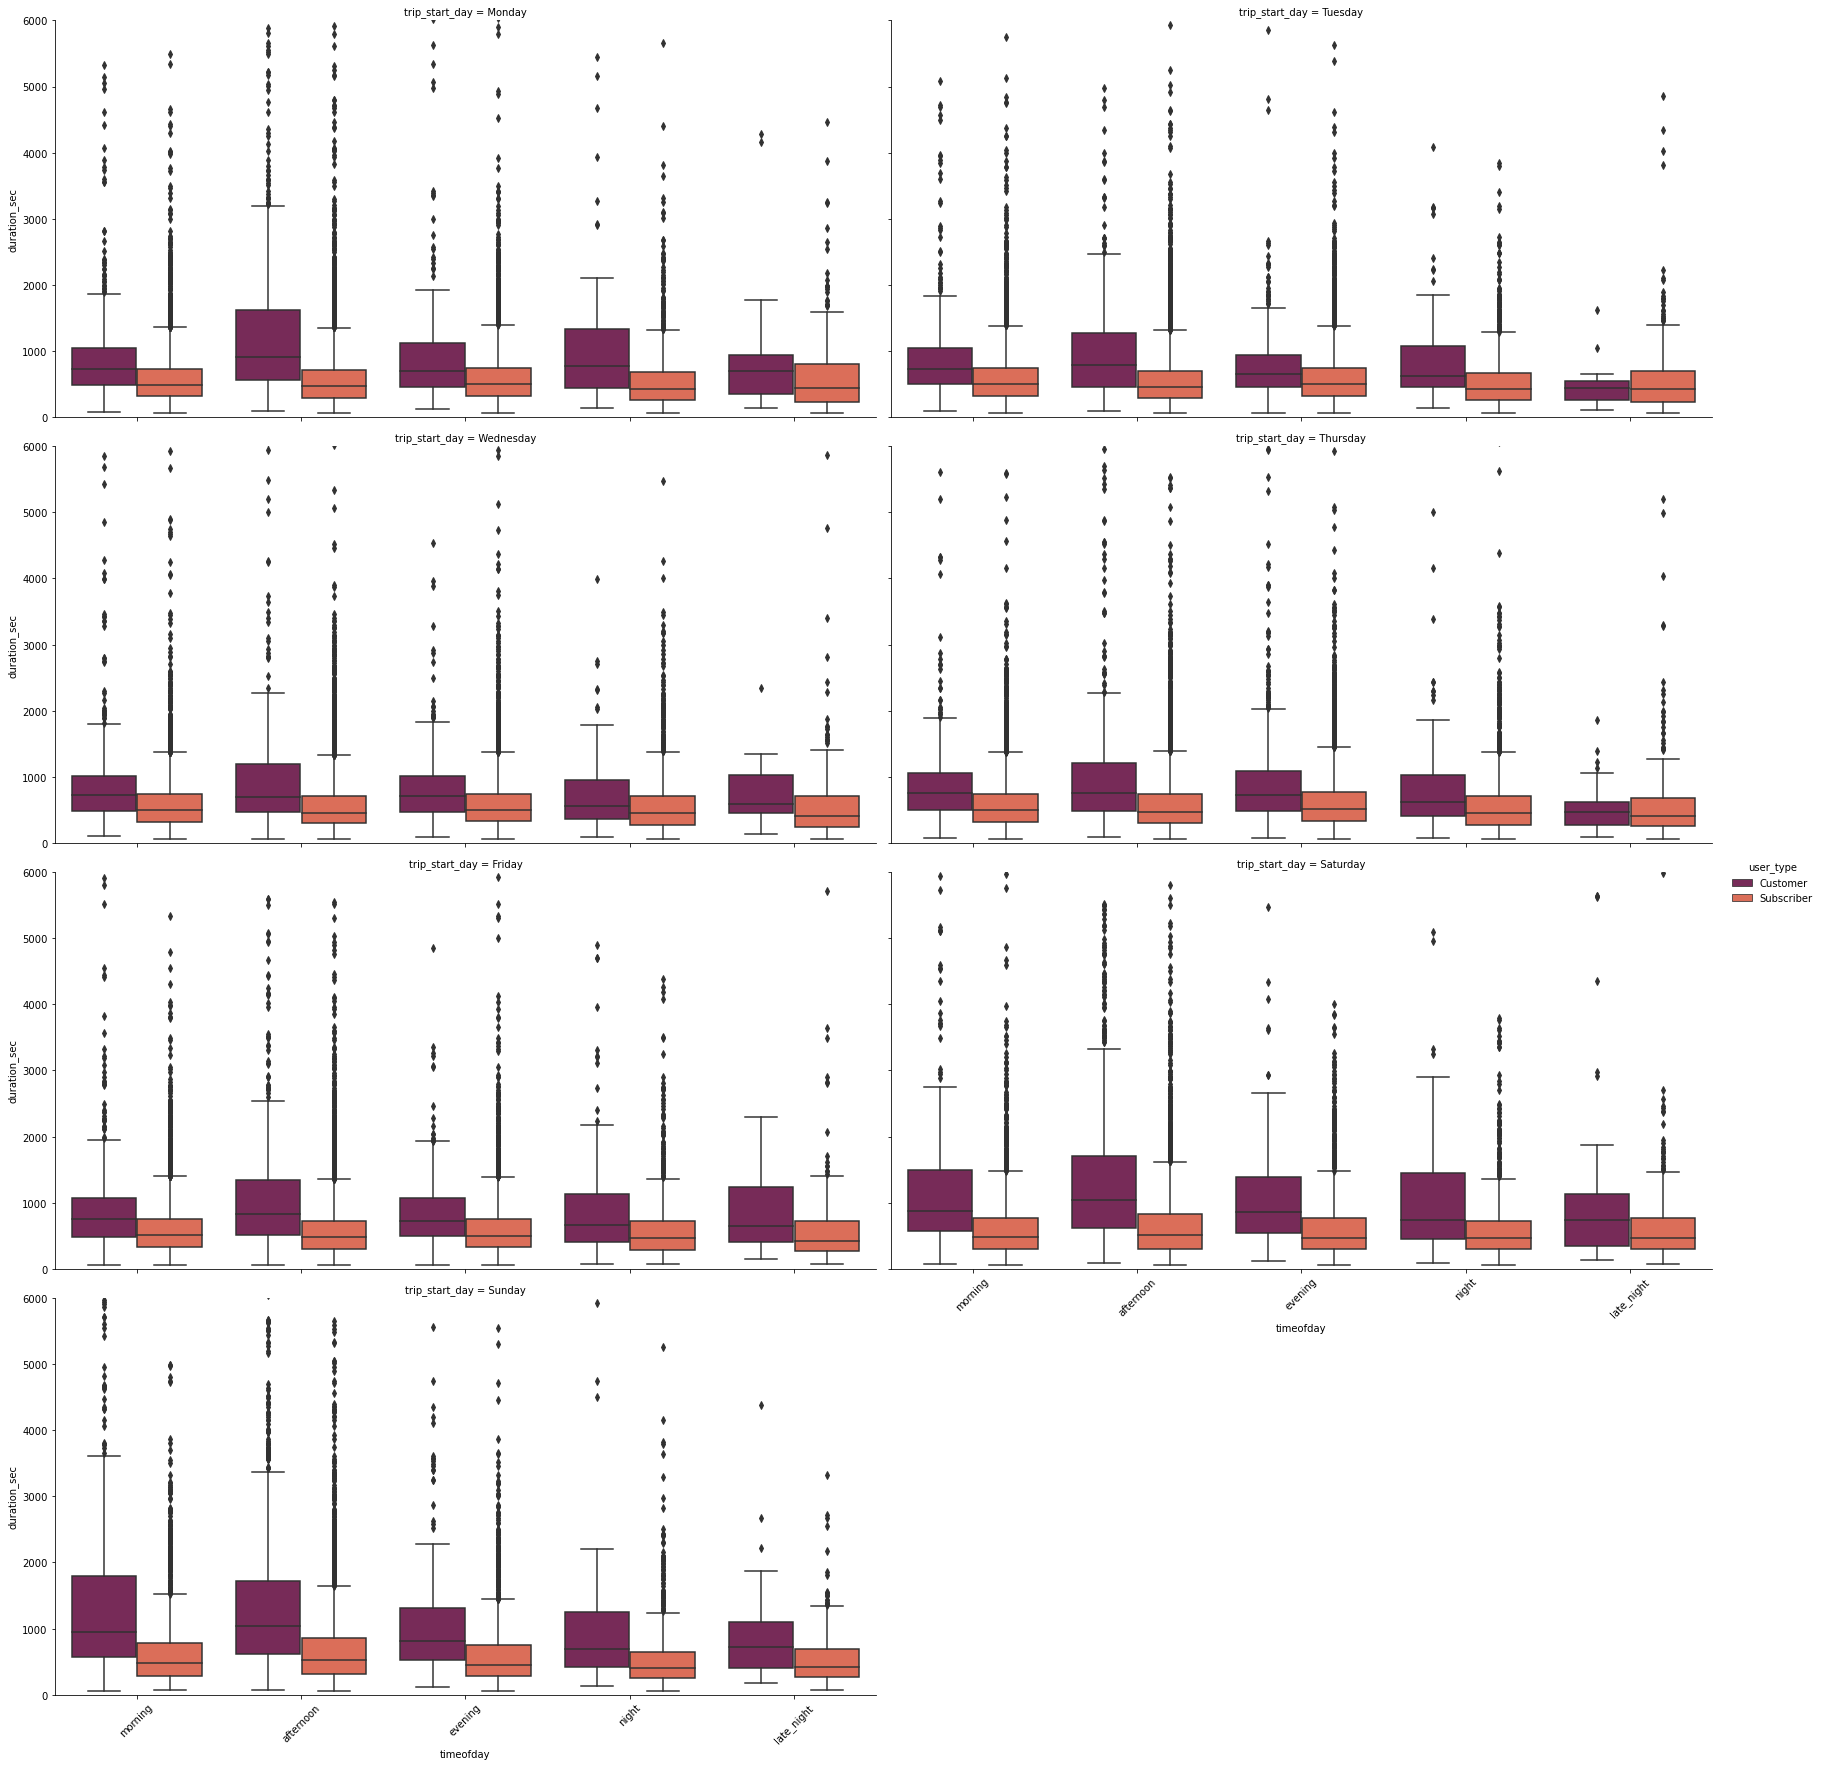

In [84]:
plt.figure(figsize=[30,20])
g = sb.catplot(data=df, x='timeofday', y='duration_sec', hue='user_type', col='trip_start_day', kind='box',
                height=6, aspect=2, palette='rocket',col_wrap = 2)
g.set(ylim=(0, 6000))
g.set_xticklabels(rotation=45);

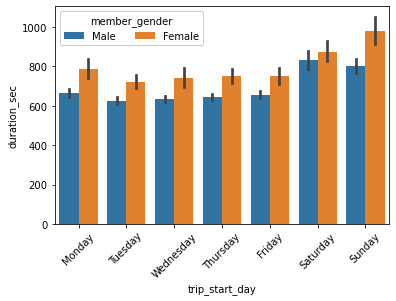

In [85]:
sb.barplot(data = df, x = 'trip_start_day', y = 'duration_sec', hue = 'member_gender')
plt.legend(loc = 'upper left', ncol = 3, framealpha = 1, title = 'member_gender')
plt.xticks(rotation=45);

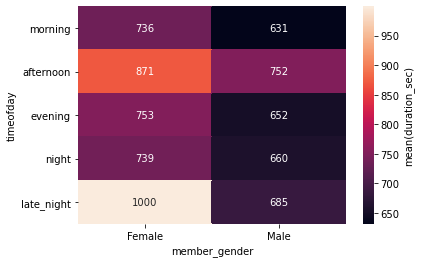

In [66]:
cat_means = df.groupby(['member_gender', 'timeofday']).mean()['duration_sec']
cat_means = cat_means.reset_index(name = 'duration_sec_avg')
cat_means = cat_means.pivot(index = 'timeofday', columns = 'member_gender',
                            values = 'duration_sec_avg')
sb.heatmap(cat_means, annot = True, fmt = '.0f',
           cbar_kws = {'label' : 'mean(duration_sec)'});

Females tend to ride for longer on average than males, a pattern that holds true whether or not we are looking at weekdays vs. weekends; they also have more rides in the afternoons than at other times of day, except for late night.

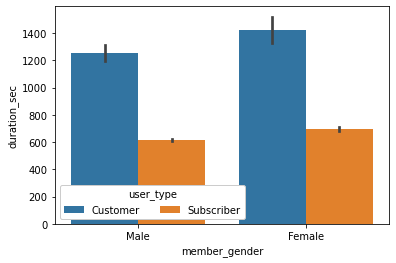

In [86]:
sb.barplot(data = df, x = 'member_gender', y = 'duration_sec', hue = 'user_type')
plt.legend(loc = 'lower left', ncol = 3, framealpha = 1, title = 'user_type');

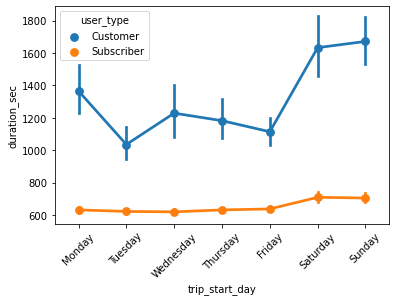

In [29]:
# Trip duration by customer type and day of week
sb.pointplot(data= df, x='trip_start_day', y='duration_sec', hue = 'user_type')
plt.xticks(rotation=45);

### Transit-station trips vs. non-transit station trips

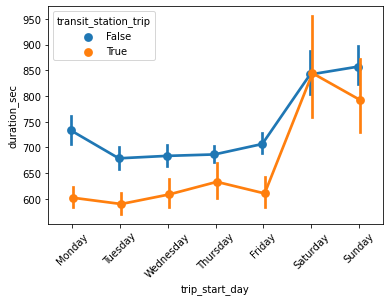

In [87]:
sb.pointplot(data = df, x = 'trip_start_day', y = 'duration_sec', hue = 'transit_station_trip',
                  dodge = True)
plt.xticks(rotation=45);

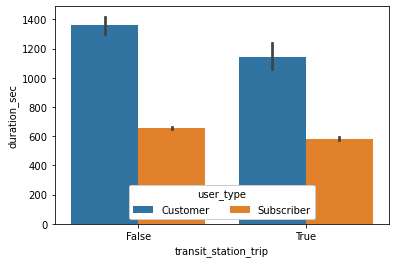

In [88]:
sb.barplot(data = df, x = 'transit_station_trip', y = 'duration_sec', hue = 'user_type')
plt.legend(loc = 'lower center', ncol = 3, framealpha = 1, title = 'user_type');

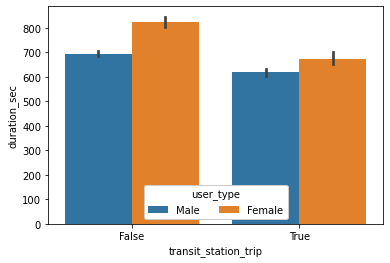

In [89]:
sb.barplot(data = df, x = 'transit_station_trip', y = 'duration_sec', hue = 'member_gender')
plt.legend(loc = 'lower center', ncol = 3, framealpha = 1, title = 'user_type');

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

The date/time variables proved to be significant predictors of trip duration, as not only did we validate that trips tend to be longer on weekends than on weekdays, but that held true across the two various customer types and in both trips involving transit stations and trips not involving transit stations.

Among user characteristics, customers appear to use the bike share service a lot more throughout the week as compared to subscribers, who frequent the service during popular commute hours. It is also worth noting that while weekend trips are longer across all user ages, the difference in trip duration between weekdays and weekends gets larger for users older than 35 years and up to 60 years of age. At that point, the difference between weekday and weekend trip duration seems to be very small. Additionally, female customers have the highest trip duration on average than any other user type.

I also found that trips that do not involve a transit station are longer on average than trips that do. 


### Were there any interesting or surprising interactions between features?

The relationship between user age, user type, and trip duration points to a usage pattern of older users either visiting the Bay Area for leisure or business or not subscribing to the service while using it regularly.